In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
X, y = make_classification(n_samples=2000, n_features=15, n_classes=2)
X.shape, y.shape

((2000, 15), (2000,))

In [3]:
# X = np.hstack([np.ones((1000, 1)), X]) # to add intercept

In [4]:
X.mean(axis=0), X.std(axis=0) # no need to standardize

(array([-0.03667018,  0.01492523, -0.0309746 , -0.00484411,  0.00367379,
         0.01218334, -0.01877608,  0.0129552 , -0.00875274, -0.00455315,
         0.00346756, -0.05650412, -0.00218682,  0.00145769, -0.00260444]),
 array([0.99795658, 1.28405013, 1.01251298, 0.99287907, 0.61233477,
        1.31128043, 1.00480726, 0.99362362, 0.99476704, 0.96760842,
        0.99098167, 1.00929525, 0.17494743, 0.99223004, 1.00147478]))

## My Logistic Regression Class realization

### Features to add:
- <b>Different types of gradient descent (GD) </b>
    - Full GD (already implemented)
    - stochastic GD (SGD) one random object used to find gradient
    - stochastic average SAGD (several random objects used to find gradient)
    
- <b>Different loss functions </b>
    - Logloss (already implemented)
    - MSE :) for fun
- <b>Info about model </b>
    - Coefficients, intercept, parameters set (learning rate, regularization)
    - Stats (p-values, confidence intervals, model adequacy)
    - Quality metrics w
- <b> Marginal Effects (ME) </b>
        - ME for each factor (done)
        - ME at means, median, at any factors given (done)
        - average ME (AME) for each factor (done)
- <b> Non-linear factors </b>
        - ME for them also

In [5]:
class Logreg:
    def __init__(self, learning_rate=0.001, iterations=2000, C=2.0):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.C = C
        self.weights = None
        self.intercept = None
        
        # history
        self.iters_list = []
        self.loss_list = []
    
    def fit(self, X, y):
        # number of observations
        n = len(y)
        # number of features
        k = X.shape[1]
        
        # recreate history variables in case we fitted model before
        self.iters_list = []
        self.loss_list = []
        
        # 1. Initialize weights
        self.weights = np.zeros(k)
        self.intercept = 0
        
        for iteration in range(self.iterations):
            # 2 Predict
            z = np.dot(X, self.weights) + self.intercept
            y_hat = 1 / (1 + np.exp(-z))
            # 3 Calculate logloss
            #logloss = np.sum(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
            logloss = np.sum(np.log(1 + np.exp(- y * y_hat))) + self.C *(np.sum(self.weights**2) +self.intercept**2)
        
            # 4 Derivative by weights
            derivative_weights = (1 / n) * np.dot(X.T, (y_hat - y)) + 2*self.C / n # (a - y) * x
            derivative_intercept = (1 / n) * np.sum(y_hat - y) + 2*self.C / n

            # 5 Update weights
            self.weights -= self.learning_rate * derivative_weights
            self.intercept -= self.learning_rate * derivative_intercept
            
            #print('Iteration:', iteration, 'Total logLoss =', logloss)
            
            # history update
            self.iters_list.append(iteration)
            self.loss_list.append(logloss)
            # 6 Repeat
    

    def predict(self, X):
        z = np.dot(X, self.weights) + self.intercept
        pred = 1 / (1 + np.exp(-z))
        return np.array([1 if i > 0.5 else 0 for i in pred])
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.intercept
        return 1 / (1 + np.exp(-z))
    
    def marginal_effects(self, X, option='all'):
        n, k = X.shape
        if option == 'all':
            z = np.dot(X, self.weights) + self.intercept
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2).reshape(n, 1), logreg.weights.reshape(k, 1).T)
        elif option == 'at_means':
            z = np.dot(logreg.weights, np.mean(X, axis=0))
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)
        elif option == 'at_median':
            z = np.dot(logreg.weights, np.median(X, axis=0))
            return np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)
        else:
            return 'Specify one of the following options: all, at_means or at_median'

### Instantiate, Fit and Predict

In [6]:
logreg = Logreg(C=1.0)

In [7]:
from sklearn.preprocessing import scale

In [8]:
X_scaled = scale(X)

In [9]:
logreg.fit(X, y)

In [10]:
mine_pred = logreg.predict(X)
np.unique(mine_pred)

array([0, 1])

#### Loss graph by iteration

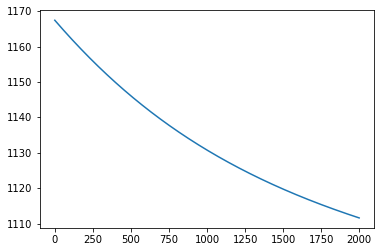

In [11]:
plt.plot(logreg.iters_list, logreg.loss_list)

#### Marginal effects for factors

In [12]:
marginal_effects = logreg.marginal_effects(X)

In [13]:
marginal_effects.shape

(2000, 15)

In [14]:
marginal_effects[:, 0] # for X1 factor

array([0.00100148, 0.00101057, 0.00044951, ..., 0.00101748, 0.00101161,
       0.00086596])

In [15]:
marginal_effects[0, :] # for all factors for the first observation

array([ 1.00148319e-03,  1.70832588e-01,  4.01800156e-03, -2.46169049e-03,
       -1.91022844e-02,  4.44082166e-03,  7.79475087e-03, -2.75704128e-03,
       -1.33372655e-04, -3.48543795e-03,  2.75369989e-03,  7.96327798e-03,
       -2.38042891e-02, -5.15407233e-04,  1.98624052e-03])

In [16]:
logreg.marginal_effects(X, option='at_means')

array([ 1.01780650e-03,  1.73617011e-01,  4.08349150e-03, -2.50181391e-03,
       -1.94136350e-02,  4.51320319e-03,  7.92179854e-03, -2.80197866e-03,
       -1.35546513e-04, -3.54224757e-03,  2.79858281e-03,  8.09307250e-03,
       -2.41922783e-02, -5.23807923e-04,  2.01861451e-03])

In [17]:
logreg.marginal_effects(X, option='at_median')

array([ 1.01652788e-03,  1.73398906e-01,  4.07836164e-03, -2.49867102e-03,
       -1.93892468e-02,  4.50753351e-03,  7.91184683e-03, -2.79845869e-03,
       -1.35376234e-04, -3.53779764e-03,  2.79506711e-03,  8.08290563e-03,
       -2.41618869e-02, -5.23149893e-04,  2.01607864e-03])

## Sklearn

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr = LogisticRegression(C=1.0)

In [20]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
lr.intercept_

array([0.15306054])

In [22]:
lr.coef_

array([[ 1.82030601e-02,  2.93474235e+00,  1.52766323e-01,
        -5.77462255e-02, -3.60890794e-01, -8.95616637e-03,
         1.11894060e-01, -2.77137295e-02, -2.53162583e-03,
        -4.04259357e-02,  1.91928992e-02,  1.22295272e-01,
        -3.98093673e-01, -3.91775475e-02,  1.01562956e-01]])

In [23]:
pred = lr.predict(X)

In [24]:
y.shape, pred.shape

((2000,), (2000,))

In [25]:
np.unique(y), np.unique(pred)

(array([0, 1]), array([0, 1]))

## Comparison: Mine VS Sklearn

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [27]:
accuracy_score(y, pred), roc_auc_score(y, pred)

(0.9065, 0.9064874064874064)

In [28]:
accuracy_score(y, mine_pred), roc_auc_score(y, mine_pred)

(0.907, 0.906978906978907)

In [29]:
logreg.weights

array([ 4.07128201e-03,  6.94477602e-01,  1.63341908e-02, -1.00073933e-02,
       -7.76556088e-02,  1.80530612e-02,  3.16876302e-02, -1.12080689e-02,
       -5.42193514e-04, -1.41691853e-02,  1.11944853e-02,  3.23727355e-02,
       -9.67704450e-02, -2.09526053e-03,  8.07456917e-03])

#### Predictions check for my logreg

In [30]:
mine_pred_proba = logreg.predict_proba(X)

In [31]:
mine_pred_proba[0], mine_pred[0]

(0.5633468066086639, 1)

In [32]:
one_obs = X[0, :].T

In [33]:
z = np.dot(one_obs, logreg.weights) + logreg.intercept

In [34]:
1 / (1 + np.exp(-z)) # prediction is correct

0.5633468066086639

In [35]:
one_obs

array([ 0.24000804,  0.43804054,  0.330261  ,  1.16558272,  0.14880509,
        0.44853981, -1.41070296, -0.86204044, -0.48482581,  0.3547128 ,
       -0.58756988,  0.16258274, -0.06538799,  0.72961785, -0.14515774])

In [36]:
one_obs[0] = one_obs[0] + 1

In [37]:
one_obs

array([ 1.24000804,  0.43804054,  0.330261  ,  1.16558272,  0.14880509,
        0.44853981, -1.41070296, -0.86204044, -0.48482581,  0.3547128 ,
       -0.58756988,  0.16258274, -0.06538799,  0.72961785, -0.14515774])

In [38]:
z = np.dot(one_obs, logreg.weights) + logreg.intercept

In [39]:
1 / (1 + np.exp(-z))

0.5643480301961916

### Marginal Effects

In [40]:
# 1 / (1 + e^(-z)) where z = b0 + b1*x1 + ... + bn*xn
# so the ME for X1 will be e^(-z)/(1 + e^(-z))^2 * b1

#### Marginal effect for one observation

In [41]:
X[0, :].shape, logreg.weights.shape

((15,), (15,))

In [42]:
z = np.dot(X[0, :].T, logreg.weights) + logreg.intercept

In [43]:
logreg.weights[0] # the sign is negative, so the ME should also be negative

0.004071282008505535

In [44]:
np.exp(-z) / (1 + np.exp(-z))**2 * logreg.weights[0] # ME for X1 for one observation
# if X1 increases by 1 then probability of getting y=1 is decreased by this number

0.0010009626709636908

#### Another way of getting marginal effect using difference of probabilities

In [45]:
x = X[0, :].T

In [46]:
x

array([ 1.24000804,  0.43804054,  0.330261  ,  1.16558272,  0.14880509,
        0.44853981, -1.41070296, -0.86204044, -0.48482581,  0.3547128 ,
       -0.58756988,  0.16258274, -0.06538799,  0.72961785, -0.14515774])

In [47]:
z_0 = np.dot(x, logreg.weights) + logreg.intercept

In [48]:
z_0

0.2588274458062403

In [49]:
z_0 = 1 / (1 + np.exp(-z_0))

In [50]:
z_0

0.5643480301961916

In [51]:
x[0] = x[0] + 1

In [52]:
x

array([ 2.24000804,  0.43804054,  0.330261  ,  1.16558272,  0.14880509,
        0.44853981, -1.41070296, -0.86204044, -0.48482581,  0.3547128 ,
       -0.58756988,  0.16258274, -0.06538799,  0.72961785, -0.14515774])

In [53]:
z_1 = np.dot(x, logreg.weights) + logreg.intercept

In [54]:
z_1

0.26289872781474577

In [55]:
z_1 = 1 / (1 + np.exp(-z_1))

In [56]:
z_1

0.5653487293227778

In [57]:
z_0, z_1

(0.5643480301961916, 0.5653487293227778)

In [58]:
z_1 - z_0 # MARGINAL EFFECT FOR THE FIRST OBSERVATION. THE SAME AS IN THE BEGINING

0.0010006991265861798

#### Marginal effect for X1 and for all factors

In [59]:
X.shape, logreg.weights.shape

((2000, 15), (15,))

In [60]:
z = np.dot(X, logreg.weights) + logreg.intercept

In [61]:
ME_x1 = np.exp(-z) / (1 + np.exp(-z))**2 * logreg.weights[0]

In [62]:
z.shape, logreg.weights.shape

((2000,), (15,))

In [63]:
ME_all = np.dot((np.exp(-z) / (1 + np.exp(-z))**2).reshape(2000, 1), logreg.weights.reshape(15, 1).T)

In [64]:
ME_all.shape

(2000, 15)

In [65]:
ME_all[:6, 0] # ME for X1

array([0.00100043, 0.00101057, 0.00044951, 0.00067197, 0.00097612,
       0.00091066])

In [66]:
ME_x1[:6] # also ME for X1 but calculated separately

array([0.00100043, 0.00101057, 0.00044951, 0.00067197, 0.00097612,
       0.00091066])

In [67]:
np.mean(ME_x1) # AME average marginal effect for X1

0.0008504749181386991

In [68]:
logreg.marginal_effects(X)[:, 0].mean()

0.0008504749181386991

In [69]:
np.median(X, axis=0).reshape(1, 15)

array([[-0.05473893, -0.09981011, -0.02099247,  0.00176019, -0.08463836,
        -0.25326815,  0.01373517,  0.01741207,  0.0117126 , -0.00578525,
        -0.02174051, -0.05497127,  0.01496919,  0.00336274, -0.03000014]])

In [70]:
z = np.dot(logreg.weights, np.median(X, axis=0))

In [71]:
np.dot((np.exp(-z) / (1 + np.exp(-z))**2), logreg.weights)

array([ 1.01652788e-03,  1.73398906e-01,  4.07836164e-03, -2.49867102e-03,
       -1.93892468e-02,  4.50753351e-03,  7.91184683e-03, -2.79845869e-03,
       -1.35376234e-04, -3.53779764e-03,  2.79506711e-03,  8.08290563e-03,
       -2.41618869e-02, -5.23149893e-04,  2.01607864e-03])

In [72]:
logreg.marginal_effects(X, option='at_median')

array([ 1.01652788e-03,  1.73398906e-01,  4.07836164e-03, -2.49867102e-03,
       -1.93892468e-02,  4.50753351e-03,  7.91184683e-03, -2.79845869e-03,
       -1.35376234e-04, -3.53779764e-03,  2.79506711e-03,  8.08290563e-03,
       -2.41618869e-02, -5.23149893e-04,  2.01607864e-03])